In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
from IPython.display import HTML

In [2]:
import sys
import os

p = !pwd
p = os.path.dirname(p[0])
if p not in sys.path:
    sys.path.append(p)

from experanto.experiment import Experiment
from experanto.interpolators import Interpolator
from experanto.interpolators import ScreenInterpolator

**Experiment** class is the essense of experanto, and it is used to load an experiment from the **root_folder**. Root folder normally has sub-folders for each modality and a meta file. See /experanto/docs/source/concepts/demo_data.rst for more details.

Experiment class can take a modality config file. We can see the default modality config file in the next cell.   
One can for example change interpolation method directly from the config file. 

In [3]:
from omegaconf import OmegaConf
from experanto.configs import DEFAULT_MODALITY_CONFIG

print(OmegaConf.to_yaml(DEFAULT_MODALITY_CONFIG))

screen:
  keep_nans: false
  sampling_rate: 30
  chunk_size: 60
  valid_condition:
    tier: train
  offset: 0
  sample_stride: 1
  include_blanks: true
  transforms:
    normalization: normalize
    Resize:
      _target_: torchvision.transforms.v2.Resize
      size:
      - 144
      - 256
  interpolation:
    rescale: true
    rescale_size:
    - 144
    - 256
responses:
  keep_nans: false
  sampling_rate: 8
  chunk_size: 16
  offset: 0.0
  transforms:
    normalization: standardize
  interpolation:
    interpolation_mode: nearest_neighbor
  filters:
    nan_filter:
      __target__: experanto.filters.common_filters.nan_filter
      __partial__: true
      vicinity: 0.05
eye_tracker:
  keep_nans: false
  sampling_rate: 30
  chunk_size: 60
  offset: 0
  transforms:
    normalization: normalize
  interpolation:
    interpolation_mode: nearest_neighbor
  filters:
    nan_filter:
      __target__: experanto.filters.common_filters.nan_filter
      __partial__: true
      vicinity: 0.05
t

In [ ]:
root_folder = "/data/dynamic27204-5-13-Video-021a75e56847d574b9acbcc06c675055_30hz"

e = Experiment(root_folder, modality_config=DEFAULT_MODALITY_CONFIG)

**devices** attribute of **Experiment** object shows the available modalities from the actual experiments and their interpolators.  
In the following we have recorded eye_tracker, (neuronal) responses, screen (or image/video stimuli), treadmill (running speed) modalities.

In [5]:
e.devices

{'eye_tracker': <experanto.interpolators.SequenceInterpolator at 0x14d1a0a13da0>,
 'responses': <experanto.interpolators.PhaseShiftedSequenceInterpolator at 0x14d1a0ed7e60>,
 'screen': <experanto.interpolators.ScreenInterpolator at 0x14d1a0a114f0>,
 'treadmill': <experanto.interpolators.SequenceInterpolator at 0x14d1a0796480>}

We can also see the start and end time of the experiment

In [6]:
print("Experiment starts at", e.start_time)
print("Experiment ends at", e.end_time)

Experiment starts at 1648159120.9446151
Experiment ends at 1648166613.4836903


#### Let's see what was on the screen

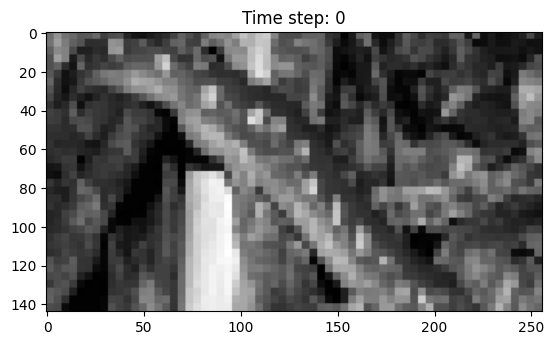

In [7]:
# Show part of the screen
times = np.arange(e.start_time+100, e.start_time+2000, 20)
time_steps = len(times)
video, valid = e.interpolate(times, device="screen")

fig, ax = plt.subplots()
im = ax.imshow(video[0], cmap="gray")


def update(frame):
    im.set_data(video[frame])
    ax.set_title(f"Time step: {frame}")
    return [im]


ani = animation.FuncAnimation(fig, update, frames=range(time_steps), repeat=False)
HTML(ani.to_jshtml())

#### Now let's visualize other data modalities, running speed as example

In [8]:
data, valid = e.interpolate(times, device="treadmill")

Text(0, 0.5, 'Running speed')

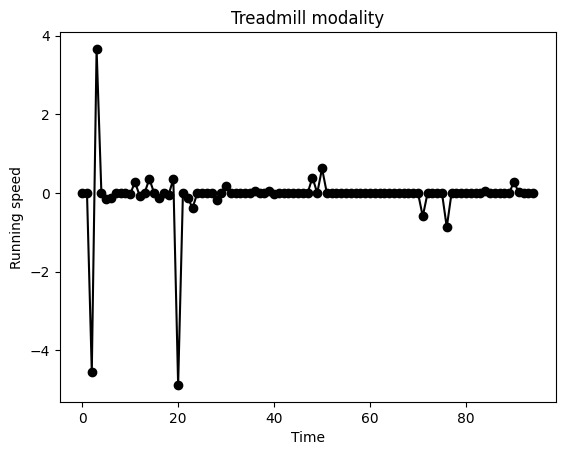

In [9]:
plt.plot(data, "o-k")
plt.title("Treadmill modality")
plt.xlabel("Time")
plt.ylabel("Running speed")

#### this is the example that interpolation is close and consistent

In [10]:
times = np.arange(e.start_time+100, e.start_time+2000, 20)
time_steps = len(times)
b = e.start_time + 100
vid1, valid = e.interpolate(times, device="screen")
vid2, valid = e.interpolate(times, device="screen")

np.sum(vid1 - vid2)

np.float32(0.0)